# Stability Pairwise ARI

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
import sklearn.metrics
from tqdm import tqdm
import numpy as np
import pickle
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import corc.our_datasets

path = cache_path = '../../cache/'

In [3]:
def setup_plot_style():
    """Define common style elements for plots."""
    return {
        'colors': {
            'mnist': "#e41a1c", # red
            'densired': "#87CEEB", # light blue (earlier: cyan)
            'densired_soft_': "#377eb8", # blue
            'blobs1_': "#984ea3", # purple
            'blobs2_': "#4daf4a" # green
        },
        'fontsize': {
            'labels': 6,
            'ticks': 6,
            'legend': 6
        }
    }

def create_errorbar_plot(ax, data_dict, key2_labels, colors, jitter_range=(-0.1, 0.1)):
    """Create an errorbar plot for the given data."""
    # jitter = np.linspace(*jitter_range, len(key2_labels))
    for index, (key1, subdict) in enumerate(data_dict.items()):
        for i, key2 in enumerate(key2_labels):
            try: 
                vals = subdict[key2]
                mean_val = np.mean(vals)
                std_val = np.std(vals)
                label = key1[:-1] if key1.endswith('_') else key1
                translated_label = corc.our_datasets.dataset_displaynames.get(label, label)
                # if label == 'densired_soft':
                #     label = 'densired\nsoft'
                # print(jitter[i])
                ax.errorbar(
                    i +  index*0.15 - len(key2_labels) * 0.15 / 2,
                    # i + np.random.uniform(*jitter_range),
                    mean_val,
                    yerr=std_val,
                    fmt='o',
                    color=colors[key1],
                    label=label if i == 0 else "",
                    markersize=3
                )
            except:
                pass

def style_axis(ax, key2_labels, fontsize, ylabel=None):
    """Apply consistent styling to an axis."""
    ax.set_xticks(range(len(key2_labels)))
    ax.set_xticklabels(key2_labels)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=fontsize['labels'], labelpad=2)
    ax.tick_params(labelsize=fontsize['ticks'])
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

def plot_comparison(ari_per_ds_bw, ari_overclust, figsize=(3.5, 1.8)):
    """Create a comparison plot with two subplots and outside legend."""
    style = setup_plot_style()
    key2_labels = list(next(iter(ari_per_ds_bw.values())).keys())
    
    # Create figure with gridspec
    fig = plt.figure(figsize=figsize)
    
    # Create gridspec with space for legend
    gs = fig.add_gridspec(2, 3, height_ratios=[1, 0.1], width_ratios=[1, 1, 0.3])
    
    # Create main subplot axes
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
    
    # Create errorbar plots
    create_errorbar_plot(ax1, ari_per_ds_bw, key2_labels, style['colors'])
    create_errorbar_plot(ax2, ari_overclust, key2_labels, style['colors'])
    
    # Style axes
    style_axis(ax1, key2_labels, style['fontsize'], ylabel="Pairwise ARI")
    style_axis(ax2, key2_labels, style['fontsize'])
    
    # Add legend to the right of the plots
    handles, labels = ax2.get_legend_handles_labels()
    legend = fig.legend(
        handles, (corc.our_datasets.dataset_displaynames[label] for label in labels),
        frameon=False,
        fontsize=style['fontsize']['legend'],
        loc='center right',
        bbox_to_anchor=(0.87, 0.6),
        handletextpad=0.01,
        scatterpoints=1
    )
    
    # Add shared x-label
    # Adjust spacing
    # plt.tight_layout()
    plt.tight_layout(w_pad=1.5)  # Increase the width padding between subplots
    plt.subplots_adjust(right=0.85)
    fig.text(0.4, 0.18, 'Dataset Dimension', 
             ha='center', va='center', 
             fontsize=style['fontsize']['labels'])
    

    # Add labels A and B relative to the y-axis label
    ax1.annotate('A', xy=(0, 1), xycoords='axes fraction',
                 xytext=(-20, -10), textcoords='offset points',
                 ha='right', va='bottom', size=10, weight='bold')
    
    ax2.annotate('B', xy=(0, 1), xycoords='axes fraction',
                 xytext=(-18, -10), textcoords='offset points',
                 ha='right', va='bottom', size=10, weight='bold')
    return fig, (ax1, ax2)

## Stability

In [17]:
ds_starts = ['mnist', 'densired', 'densired_soft_']
# ds_starts = ['mnist', 'densired', 'densired_soft_', 'blobs1_', 'blobs2_']
ds_dims = [8, 16, 32, 64]
ds_end = '_25.pkl'
# ds_end = '_35.pkl'
# gmm = '_gmm'
gmm = ""

In [18]:
# path = '/srv/user/turishcheva/cluster_vs_continuum_jan_2025/cluster_vs_continuum/cache/'
ari_per_dataset_seeds = {}
for ds_name in tqdm(ds_starts):
    ari_per_dataset_seeds[ds_name] = {}
    for dim in ds_dims:
        ari_per_dataset_seeds[ds_name][dim] = []
        
        with open(f'{path}stability/seeds_{ds_name}{dim}{gmm}{ds_end}', 'rb') as f:
            tmm_models = pickle.load(f)
            
        with open(f'{path}{ds_name}{dim}.pickle', 'rb') as f:
            ds = pickle.load(f)
            X = ds['dataset'][0]
            y = ds['dataset'][1]
        n_classes = len(np.unique(y))
        predictions = {tmm_model: tmm_model.predict_with_target(X, n_classes) for tmm_model in tmm_models}
        for model1, model2 in combinations(tmm_models, 2):
            ari_per_dataset_seeds[ds_name][dim].append(
                adjusted_rand_score(predictions[model1], predictions[model2])
            )

100%|██████████| 3/3 [00:16<00:00,  5.65s/it]

6 clusters is not achievable.
Working with 4 clusters instead.


In [22]:
ari_per_dataset_overclustering = {}
for ds_name in tqdm(ds_starts):
    ari_per_dataset_overclustering[ds_name] = {}
    for dim in ds_dims:
        if ds_name == 'blobs1_' and dim == 64:
            continue
        ari_per_dataset_overclustering[ds_name][dim] = []
        
        with open(f'{path}stability/overclustering_{ds_name}{dim}{gmm}.pkl', 'rb') as f:
            tmm_models = pickle.load(f)
        
        # skip first two models as they do not use proper "joining" of clusters
        tmm_models = tmm_models[2:10]
            
        X, y, tsne = corc.utils.load_dataset(f'{ds_name}{dim}',cache_path=cache_path)
        n_classes = len(np.unique(y))
        predictions = {s: s.predict_with_target(X, n_classes) for s in tmm_models}

        # pairwise ari
        for model1, model2 in combinations(tmm_models, 2):
            ari_per_dataset_overclustering[ds_name][dim].append(
                adjusted_rand_score(predictions[model1], predictions[model2])
            )

 67%|██████▋   | 2/3 [01:36<00:47, 47.27s/it]

6 clusters is not achievable.
Working with 5 clusters instead.


100%|██████████| 3/3 [01:43<00:00, 34.38s/it]


In [24]:
keys = ['mnist', 'densired', 'densired_soft_']
main_ari_per_dataset_seeds = {key: ari_per_dataset_seeds[key] for key in keys }
main_ari_per_dataset_overclustering = {key: ari_per_dataset_overclustering[key] for key in keys}

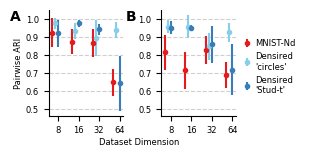

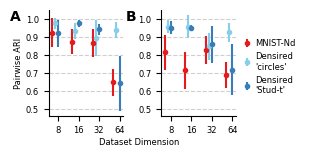

In [25]:
fig, axes = plot_comparison(ari_per_dataset_seeds, ari_per_dataset_overclustering)
plt.savefig(f"../../figures/stability_errorbars{gmm}_full.pdf",
            bbox_inches='tight', pad_inches=0)

fig, axes = plot_comparison(main_ari_per_dataset_seeds, main_ari_per_dataset_overclustering)
plt.savefig(f"../../figures/stability_errorbars{gmm}2.pdf",
            bbox_inches='tight', pad_inches=0)

## Example plot

In [5]:
import corc.utils
import os

In [6]:
def plot_mask(transformed_points, mask, best_mask, ax, s_size, title="", fontsize=12):
    ax.scatter(
        transformed_points[mask, 0],
        transformed_points[mask, 1],
        c="black",
        s=s_size,
        label="Correctly Classified",
    )
    ax.scatter(
        transformed_points[~mask, 0],
        transformed_points[~mask, 1],
        c="#e41a1c", # red
        s=s_size,
        label="Misclassified",
    )
    ax.scatter(
        transformed_points[~best_mask, 0],
        transformed_points[~best_mask, 1],
        c="orange", # orange
        s=s_size,
        label="always Misclassified",
    )
    ax.annotate(title, xy=(0.5, .97), xycoords='axes fraction', ha='center', fontsize=fontsize)
    # ax.title.set_y(1.3)
    # ax.set_title(title, fontsize=fontsize)

In [7]:
def create_plot_claude(X, transformed_points, y, tmm_model, seed=None, n_components=None, edges=False):
    """
    Create a visualization grid comparing different clustering methods.
    
    Parameters:
    -----------
    X : np.ndarray
        Original input data
    transformed_points : np.ndarray
        2D transformed points for visualization (e.g., from t-SNE)
    y : np.ndarray
        Ground truth labels
    tmm_model : object
        TMM model instance
    seed : int, optional
        Random seed for reproducibility
    n_components : int, optional
        Number of components used in the transformation
    
    Returns:
    --------
    matplotlib.figure.Figure
        The completed figure
    """
    
    def plot_single_cluster(ax, points, labels, centers=None, title=None,cmap='viridis', edges=False):
        """Helper function to plot a single cluster visualization."""
        ax.scatter(points[:, 0], points[:, 1], c=cmap[labels], s=SCATTER_SIZE)
        if centers is not None:
            ax.scatter(centers[:, 0], centers[:, 1], c="black", marker="x", s=MARKER_SIZE)
        if title:
            ax.set_title(title)
        ax.axis('off')

        if edges:
            # add lines between centers of the same cluster
            if centers is not None:
                center_colors = np.zeros(len(centers))
                for index in range(len(centers)):
                    # get color of the center
                    center_colors[index] = labels[np.where(np.logical_and(points[:,1] == centers[index,1],points[:,1] == centers[index,1]))[0][0]]
                
                for colorclass in np.unique(labels):
                    indices = np.where(center_colors == colorclass)
                    for i in range(len(indices[0])):
                        for j in range(i+1, len(indices[0])):
                            ax.plot([centers[indices[0][i], 0], centers[indices[0][j], 0]], [centers[indices[0][i], 1], centers[indices[0][j], 1]], c='black', alpha=0.5)

    def add_row_label(ax, label):
        """Helper function to add consistent row labels."""
        ax.text(-0.05, 0.5, label, transform=ax.transAxes,
                fontsize=6, rotation=90, va='center', ha='right')

    # Constants
    MARKER_SIZE = 14
    SCATTER_SIZE = 0.2
    N_ROWS, N_COLS = 2, 4
    fontsize = 12
    cmap = corc.utils.get_color_scheme(len(np.unique(y)))
    # Setup figure
    fig, axs = plt.subplots(N_ROWS, N_COLS, figsize=(6.75, 3.75))
    for ax in axs.flat:
        ax.set_aspect('equal') 
    # plt.subplots_adjust(wspace=-0.2, hspace=0.1)  # Reduced spacing between subplots
    for ax in axs.flat:
        ax.axis('off')

    # # Add row labels
    # row_labels = {
    #     0: ["Ground Truth", "Dip-stats"],
    #     1: ["Nearest Neighbor", "MDP (ours)"]
    # }
    # for row in [0, 1]:
    #     add_row_label(axs[row, 0], row_labels[row][0])
    #     add_row_label(axs[row, 2], row_labels[row][1])

    # Get centers in transformed space
    centers = corc.utils.snap_points_to_TSNE(
        tmm_model.mixture_model.centers, X, transformed_points
    )
    
    # 1. Ground Truth
    y_best = corc.utils.best_possible_labels_from_overclustering(
        y, tmm_model.mixture_model.predict(X)
    )
    correct_mask = y == y_best
    plot_single_cluster(axs[0, 0], transformed_points, y,cmap=cmap)
    axs[0, 0].set_title("Oracle", fontsize=fontsize, pad=0)
    plot_mask(
        transformed_points,
        correct_mask,
        correct_mask,
        axs[1, 0],
        title=f"ARI: {adjusted_rand_score(y, y_best):.2f}",
        s_size=SCATTER_SIZE,
        fontsize=fontsize
    )

    # 2. Baseline (Nearest Neighbor)
    y_baseline = get_baseline_predictions(tmm_model, X, y)
    plot_single_cluster(axs[0, 1], transformed_points, y_baseline, centers,cmap=cmap, edges=edges)
    axs[0, 1].set_title(" Euclidean", fontsize=fontsize, pad=0)
    plot_mask(
        transformed_points,
        (y == y_baseline),
        correct_mask,
        axs[1, 1],
        title=f"ARI: {adjusted_rand_score(y, y_baseline):.2f}",
        s_size=SCATTER_SIZE,
        fontsize=fontsize
    )

    # 3. Dip-stats
    y_dip = get_dip_stat_predictions(tmm_model, X, y)
    plot_single_cluster(axs[0, 2], transformed_points, y_dip, centers,cmap=cmap, edges=edges)
    axs[0, 2].set_title(" Dip-stats", fontsize=fontsize, pad=0)
    plot_mask(
        transformed_points,
        (y == y_dip),
        correct_mask,
        axs[1, 2],
        title=f"ARI: {adjusted_rand_score(y, y_dip):.2f}",
        s_size=SCATTER_SIZE,
        fontsize=fontsize
    )

    # 4. Our method (MDP)
    y_pred = tmm_model.predict_with_target(X, len(np.unique(y)))
    y_pred = corc.utils.reorder_colors(y_pred, y)
    plot_single_cluster(axs[0, 3], transformed_points, y_pred, centers,cmap=cmap, edges=edges)
    axs[0, 3].set_title(r"  NEB (ours)", fontsize=fontsize, pad=0)
    plot_mask(
        transformed_points,
        (y == y_pred),
        correct_mask,
        axs[1, 3],
        title=f"ARI: {adjusted_rand_score(y, y_pred):.2f}",
        s_size=SCATTER_SIZE,
        fontsize=fontsize
    )

    # A,B,C,D labels
    axs[0,0].annotate('A', xy=(0, 1), xycoords='axes fraction',
                xytext=(25, 0), textcoords='offset points',
                ha='right', va='bottom', size=fontsize+4, weight='bold')
    axs[0,1].annotate('B', xy=(0, 1), xycoords='axes fraction',
                xytext=(20, 0), textcoords='offset points',
                ha='right', va='bottom', size=fontsize+4, weight='bold')
    axs[0,2].annotate('C', xy=(0, 1), xycoords='axes fraction',
                xytext=(20, 0), textcoords='offset points',
                ha='right', va='bottom', size=fontsize+4, weight='bold')
    axs[0,3].annotate('D', xy=(0, 1), xycoords='axes fraction',
                xytext=(20, 0), textcoords='offset points',
                ha='right', va='bottom', size=fontsize+4, weight='bold')

    fig.tight_layout()
    plt.subplots_adjust(wspace=-0., hspace=0.)
    return fig

def get_baseline_predictions(tmm_model, X, y):
    """Get predictions using the baseline nearest neighbor method."""
    y_pred_full = tmm_model.mixture_model.predict(X)
    y_baseline = corc.utils.predict_by_joining_closest_clusters(
        centers=tmm_model.mixture_model.centers,
        y_pred=y_pred_full,
        num_classes=len(np.unique(y)),
        dip_stat=False,
        data=X
    )
    y_baseline = np.array(y_baseline, dtype=int)
    return corc.utils.reorder_colors(y_baseline, y)

def get_dip_stat_predictions(tmm_model, X, y):
    """Get predictions using the dip-stats method."""
    y_pred = tmm_model.predict(X)
    y_dip = corc.utils.predict_by_joining_closest_clusters(
        centers=tmm_model.mixture_model.centers,
        y_pred=np.asarray(y_pred.tolist()),
        num_classes=len(np.unique(y)),
        dip_stat=True,
        data=tmm_model.data
    )
    return corc.utils.reorder_colors(y_dip, y)

successfully loaded model from disk
joined 3 and 10 (both now in class 3)
joined 3 and 4 (both now in class 3)
joined 6 and 14 (both now in class 6)
joined 0 and 19 (both now in class 0)
joined 6 and 11 (both now in class 6)
joined 12 and 15 (both now in class 12)
joined 1 and 12 (both now in class 1)
joined 0 and 8 (both now in class 0)
joined 0 and 6 (both now in class 0)
joined 1 and 3 (both now in class 1)
joined 6 and 18 (both now in class 6)
joined 1 and 9 (both now in class 1)
joined 0 and 5 (both now in class 0)
joined 8 and 17 (both now in class 8)
joined 13 and 16 (both now in class 13)
joined 3 and 19 (both now in class 3)
joined 4 and 14 (both now in class 4)
joined 8 and 12 (both now in class 8)
joined 10 and 13 (both now in class 10)
joined 2 and 11 (both now in class 2)
joined 3 and 10 (both now in class 3)
joined 3 and 4 (both now in class 3)
joined 6 and 14 (both now in class 6)
joined 0 and 19 (both now in class 0)
joined 6 and 11 (both now in class 6)
joined 12 and 1

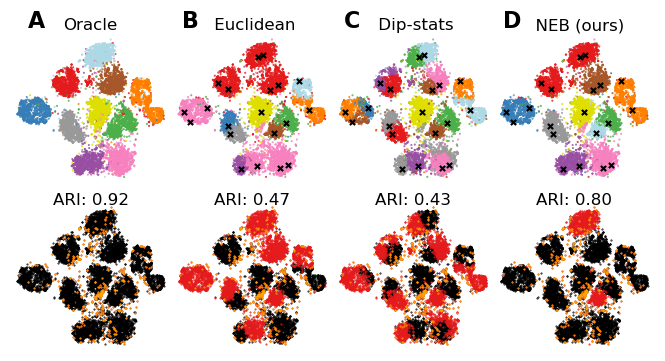

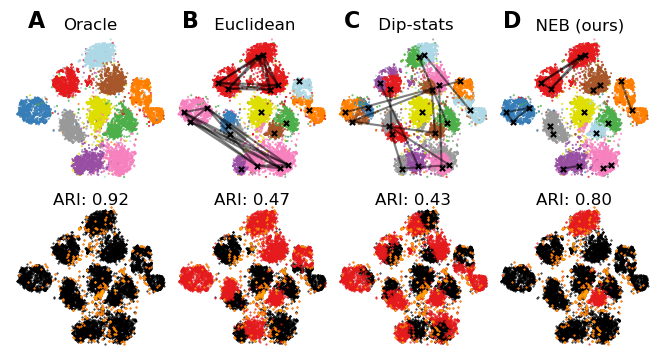

In [88]:
n_components = 25
dataset_name = 'mnist16'
# cache_path = '/srv/user/turishcheva/cluster_vs_continuum_jan_2025/cluster_vs_continuum/cache/'
seed = 42

X, y, transformed_points = corc.utils.load_dataset(
    dataset_name=dataset_name, cache_path=cache_path
)

# load tmm model
# alg_filename = f"{cache_path}stability/seeds_{dataset_name}_{n_components}.pkl"
alg_filename = f"{cache_path}/{dataset_name}_TMM-NEB.pickle"
if not os.path.exists(alg_filename):
    print(f"File {alg_filename} not found. training a new model.")
    # return -1
    tmm_model = corc.graph_metrics.neb.NEB(
        data=X, labels=y, n_components=n_components, optimization_iterations=500, seed=seed,
    )
    tmm_model.fit(X)
    with open(alg_filename, "wb") as f:
        pickle.dump(tmm_model, f)
else:
    with open(alg_filename, "rb") as f:
        tmm_model = pickle.load(f)
    print("successfully loaded model from disk")
    # n_components = len(tmm_model.mixture_model.weights)
        
# tmm_model = tmm_models[0]
figure = create_plot_claude(
    X=X, transformed_points=transformed_points, y=y, tmm_model=tmm_model, seed=seed, n_components=n_components
)
plt.savefig(f"../../figures/join_strategies_{dataset_name}_{n_components}.png",
            bbox_inches='tight', pad_inches=0, dpi=600)

figure = create_plot_claude(
    X=X, transformed_points=transformed_points, y=y, tmm_model=tmm_model, seed=seed, n_components=n_components, edges=True
)
plt.savefig(f"../../figures/join_strategies_{dataset_name}_{n_components}_edges.png",
            bbox_inches='tight', pad_inches=0, dpi=600)

# Checking low overclustering stability of MNIST16

In [8]:

ds_starts = ['mnist']
ds_dims = [16]
for ds_name in tqdm(ds_starts):
    for dim in ds_dims:
        with open(f'{path}stability/overclustering_{ds_name}{dim}.pkl', 'rb') as f:
        # with open(f'{path}stability/seeds_{ds_name}{dim}{ds_end}', 'rb') as f:
        # with open(f'{path}stability/seeds_{ds_name}{dim}_gmm{ds_end}', 'rb') as f:
            models = pickle.load(f)
            
        X,y,tsne = corc.utils.load_dataset(f'{ds_name}{dim}',cache_path=cache_path)
        n_classes = len(np.unique(y))
        for model in models:
            y_pred = model.predict_with_target(X, n_classes)
            # if n_classes != len(np.unique(y_pred)):
            print(f'{ds_name} {dim} {model.__class__.__name__} ARI: {sklearn.metrics.adjusted_rand_score(y, y_pred)} Num Clusters: {len(np.unique(y_pred))}')


  0%|          | 0/1 [00:00<?, ?it/s]

mnist 16 NEB ARI: 0.7913759546873592 Num Clusters: 10
mnist 16 NEB ARI: 0.8078963917060458 Num Clusters: 10
mnist 16 NEB ARI: 0.8034254859899681 Num Clusters: 10
mnist 16 NEB ARI: 0.8149319189414314 Num Clusters: 10
mnist 16 NEB ARI: 0.7362127535929482 Num Clusters: 10
mnist 16 NEB ARI: 0.6661617622592844 Num Clusters: 10
mnist 16 NEB ARI: 0.8103791273237935 Num Clusters: 10
mnist 16 NEB ARI: 0.6766724697039042 Num Clusters: 10


100%|██████████| 1/1 [00:10<00:00, 10.64s/it]

mnist 16 NEB ARI: 0.7385085521649548 Num Clusters: 10


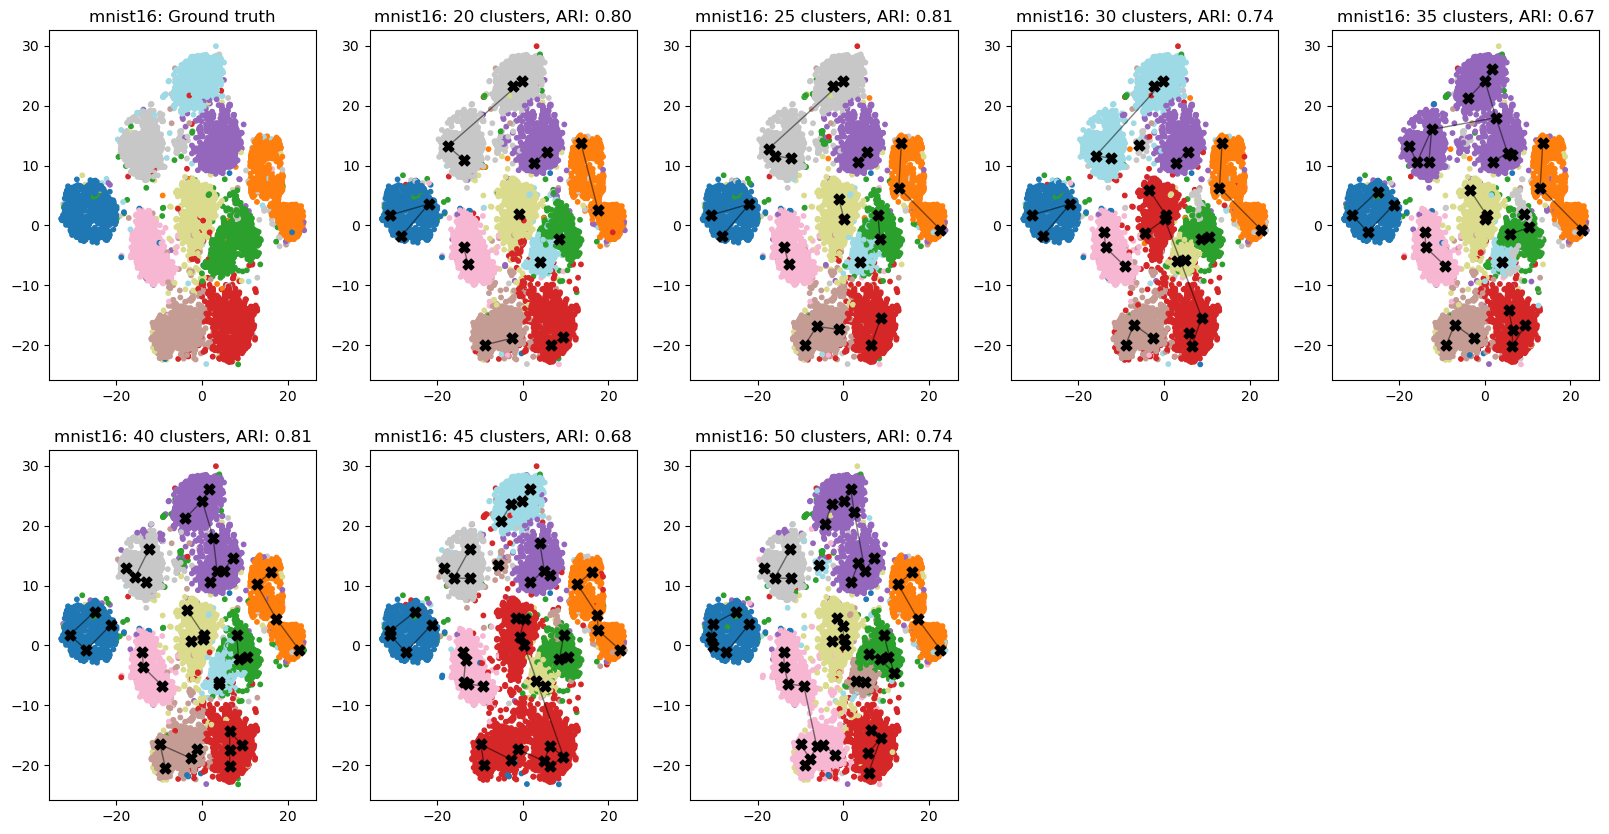

In [9]:
import corc.tmm_plots

X,y,tsne = corc.utils.load_dataset(f'mnist16',cache_path=cache_path)
corc.tmm_plots.plot_tmm_models(models[2:], X , y, "mnist16",tsne_transform=tsne)
plt.savefig(f"../../figures/overclustering_mnist16.png", bbox_inches='tight', pad_inches=0, dpi=600)

In [14]:
cmap = corc.utils.get_color_scheme(len(np.unique(y)))


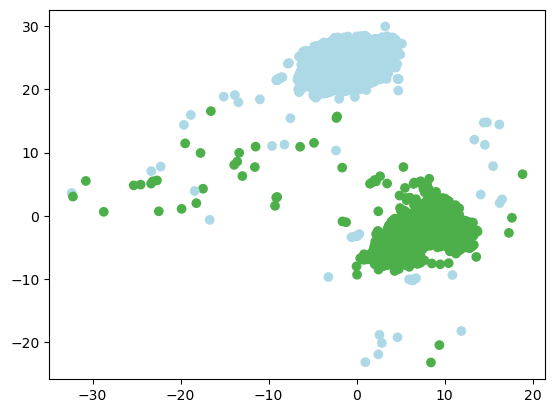

In [32]:
mask = np.isin(y, [2,9])

plt.scatter(tsne[mask, 0], tsne[mask, 1], c=cmap[y[mask]])